In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import multiprocessing

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import pandas as pd
import numpy as np
import numpyro

from hbmep.config import Config
from hbmep.model import Baseline
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()


In [2]:
root_path = Path(os.getcwd()).parent.parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/shie/fcr.toml")

config = Config(toml_path=toml_path)

model = Baseline(config=config)

df = pd.read_csv(model.csv_path)

ind = df.pulse_amplitude.isin([0])
df = df[~ind].reset_index(drop=True).copy()

""" Process """
df, encoder_dict = model.load(df=df)

""" Combinations and conditions """
subjects = df.participant.unique().tolist()

combinations = model._make_combinations(df=df, columns=model.combination_columns)   # sub x pos x charge

conditions = model._make_combinations(df=df, columns=model.combination_columns[1:]) # pos x charge

conditions_inv = [f"{encoder_dict[model.features[0]].inverse_transform(np.array([pos]))[0]}::{encoder_dict[model.features[1]].inverse_transform(np.array([charge]))[0]}" for (pos, charge) in conditions]


2023-08-09 15:17:09,796 - hbmep.config - INFO - Verifying configuration ...
2023-08-09 15:17:09,797 - hbmep.config - INFO - Success!
2023-08-09 15:17:09,814 - hbmep.model.baseline - INFO - Initialized model with baseline link
2023-08-09 15:17:09,826 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/L_SHIE/fcr
2023-08-09 15:17:09,827 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/L_SHIE/fcr
2023-08-09 15:17:09,828 - hbmep.dataset.core - INFO - Processing data ...
2023-08-09 15:17:09,831 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [3]:
def _process(src: str):
    mcmc = az.from_netcdf(os.path.join(src, "mcmc.nc"))["posterior"]
    a = mcmc[site.a].to_numpy()
    a = a.reshape(-1, *a.shape[2:])

    a = np.array(jax.random.permutation(model.rng_key, x=a, axis=0))
    a = a[..., 0]

    a_map = a.mean(axis=0)

    d = {}

    for pos, charge in conditions:
        curr_row = []
        for sub in subjects:
            if (sub, pos, charge) in combinations:
                curr_row.append(sub)
        d[(pos, charge)] = curr_row

    mat = []
    map_ = []

    for i, (i_pos, i_charge) in enumerate(conditions):
        curr_row = []

        curr_map = a_map[i_charge, i_pos, :]
        curr_map = curr_map[..., d[(i_pos, i_charge)]]
        map_.append(curr_map.mean())

        for j, (j_pos, j_charge) in enumerate(conditions):
            if i == j:
                curr_row.append(0)
                continue

            # Common participants
            common_ = set(d[(i_pos, i_charge)]).intersection(set(d[(j_pos, j_charge)]))
            common_ = list(common_)

            samples = a[:, i_charge, i_pos, :] - a[:, j_charge, j_pos, :]
            samples = samples[:, common_]
            samples = samples.mean(axis=-1)

            pr = (samples < 0).mean()
            curr_row.append(pr)

        mat.append(curr_row)


    mat = np.array(mat)
    map_ = np.array(map_)
    return mat, map_



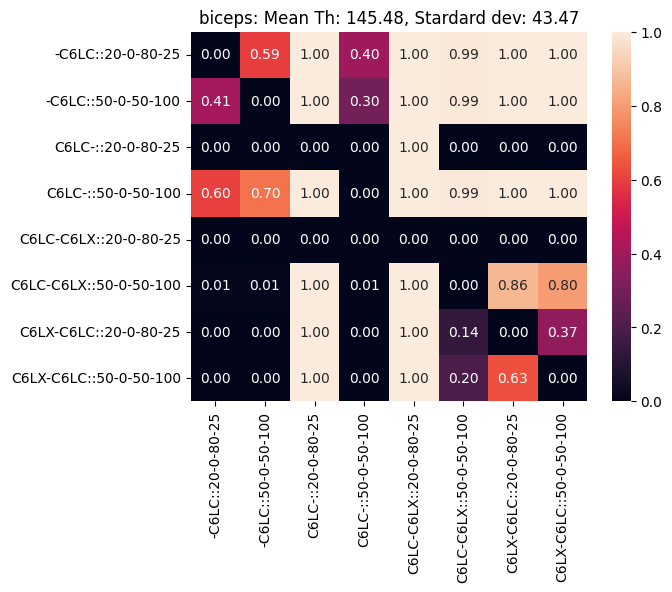

In [4]:
src = "/home/vishu/repos/hbmep-paper/reports/L_SHIE/biceps"

mat, a_map = _process(src)

mean_ = a_map.mean()
std_ = a_map.std()

sns.heatmap(mat, xticklabels=conditions_inv, yticklabels=conditions_inv, annot=True, fmt=".2f")

plt.title(f"biceps: Mean Th: {mean_:.2f}, Stardard dev: {std_:.2f}");


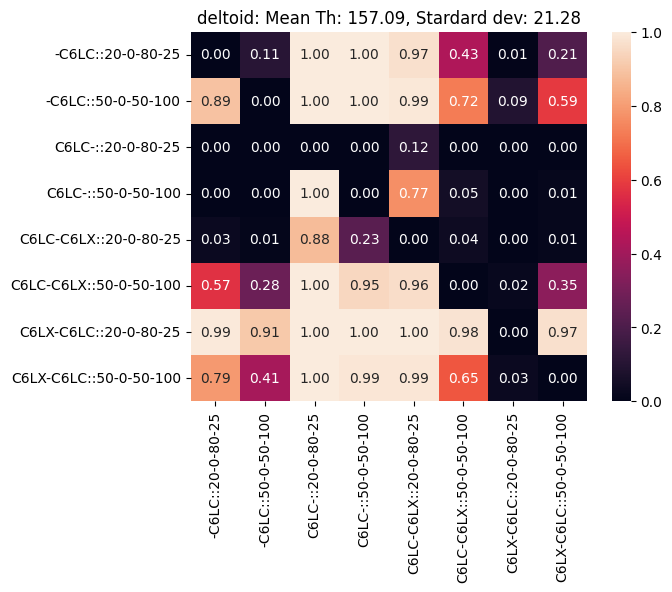

In [5]:
src = "/home/vishu/repos/hbmep-paper/reports/L_SHIE/deltoid"

mat, a_map = _process(src)

mean_ = a_map.mean()
std_ = a_map.std()

sns.heatmap(mat, xticklabels=conditions_inv, yticklabels=conditions_inv, annot=True, fmt=".2f")

plt.title(f"deltoid: Mean Th: {mean_:.2f}, Stardard dev: {std_:.2f}");

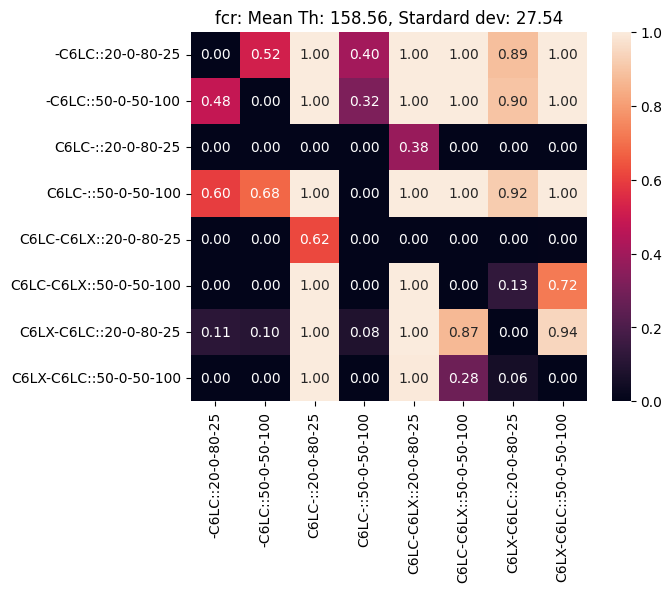

In [6]:
src = "/home/vishu/repos/hbmep-paper/reports/L_SHIE/fcr"

mat, a_map = _process(src)

mean_ = a_map.mean()
std_ = a_map.std()

sns.heatmap(mat, xticklabels=conditions_inv, yticklabels=conditions_inv, annot=True, fmt=".2f")

plt.title(f"fcr: Mean Th: {mean_:.2f}, Stardard dev: {std_:.2f}");

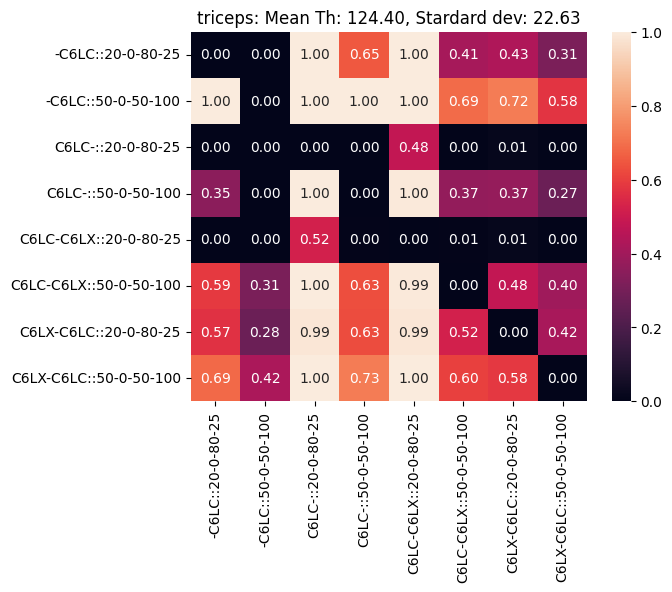

In [7]:
src = "/home/vishu/repos/hbmep-paper/reports/L_SHIE/triceps"

mat, a_map = _process(src)

mean_ = a_map.mean()
std_ = a_map.std()

sns.heatmap(mat, xticklabels=conditions_inv, yticklabels=conditions_inv, annot=True, fmt=".2f")

plt.title(f"triceps: Mean Th: {mean_:.2f}, Stardard dev: {std_:.2f}");


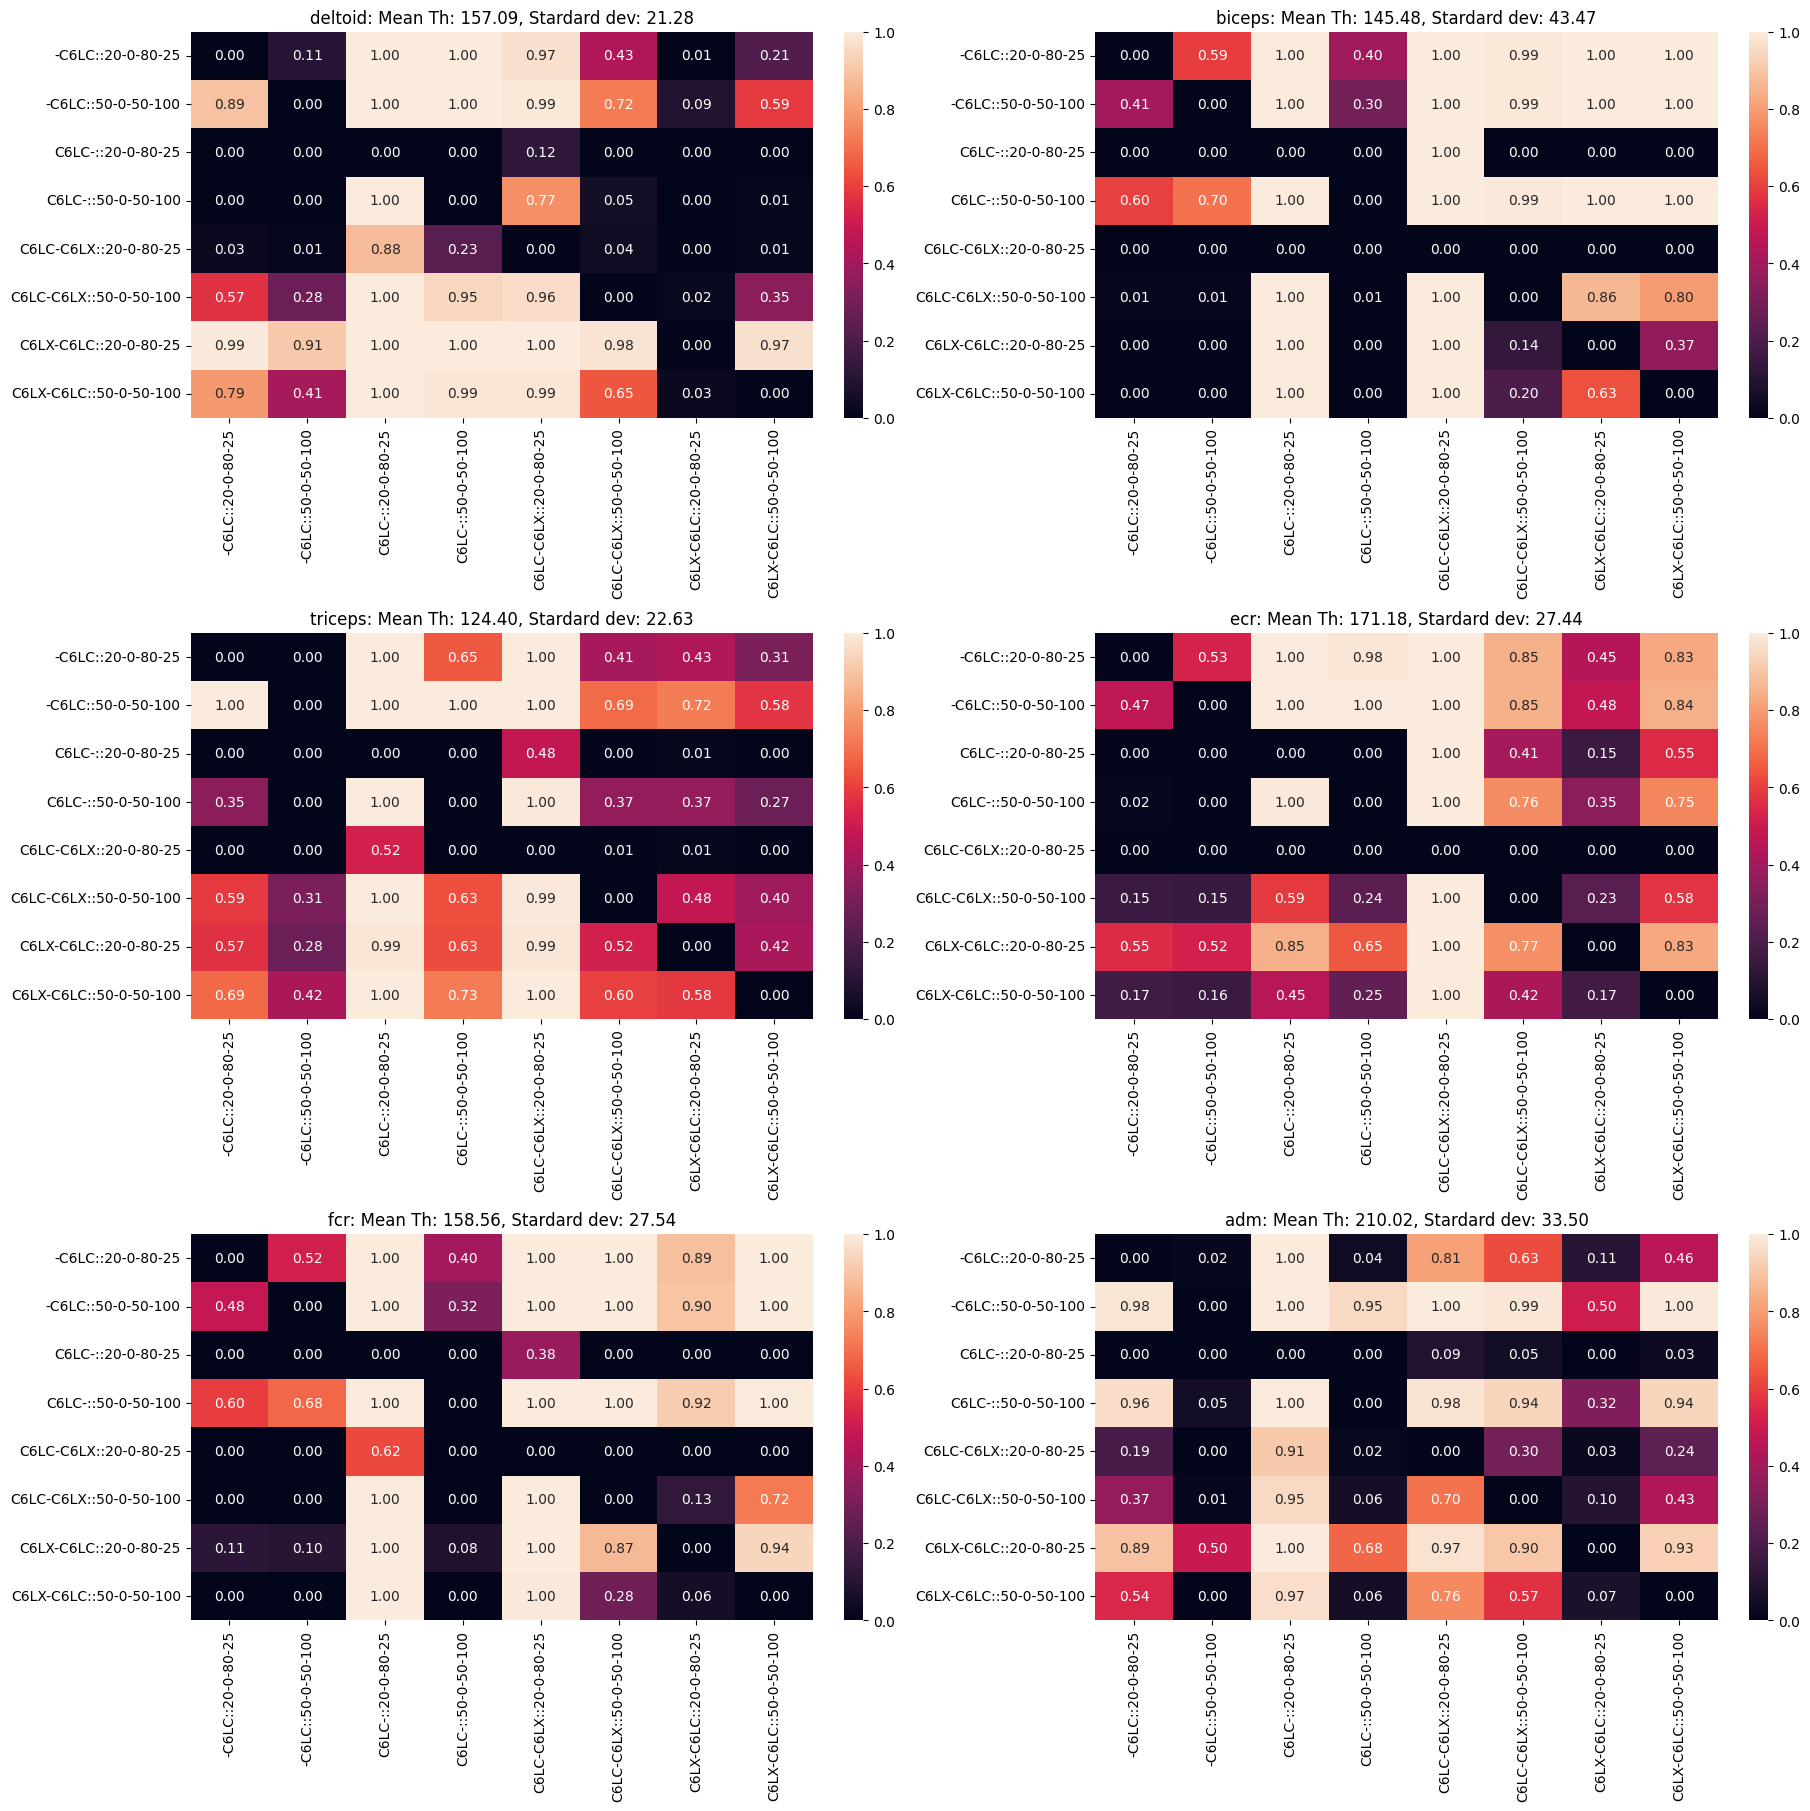

In [8]:
nrows = 3
ncols = 2

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * nrows, 6 * nrows), constrained_layout=True)


muscles = ["deltoid", "biceps", "triceps", "ecr", "fcr", "adm"]
ind = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]

for i, m in enumerate(muscles):
    src = f"/home/vishu/repos/hbmep-paper/reports/L_SHIE/{m}"

    mat, a_map = _process(src)

    mean_ = a_map.mean()
    std_ = a_map.std()

    sns.heatmap(mat, xticklabels=conditions_inv, yticklabels=conditions_inv, annot=True, fmt=".2f", ax=ax[*ind[i]])

    ax[*ind[i]].set_title(f"{m}: Mean Th: {mean_:.2f}, Stardard dev: {std_:.2f}");

In [19]:
def _process_by_muscles(muscles: list[str]):
    a_mat = None

    for i, m in enumerate(muscles):
        src = f"/home/vishu/repos/hbmep-paper/reports/L_SHIE/{m}"
        mcmc = az.from_netcdf(os.path.join(src, "mcmc.nc"))["posterior"]
        a = mcmc[site.a].to_numpy()
        a = np.array(jax.random.permutation(model.rng_key, x=a, axis=0))
        a = a.reshape(-1, *a.shape[2:])

        if a_mat is None:
            a_mat = a
        else:
            a_mat = np.concatenate((a_mat, a), axis=-1)

    d = {}

    for pos, charge in conditions:
        curr_row = []
        for sub in subjects:
            if (sub, pos, charge) in combinations:
                curr_row.append(sub)
        d[(pos, charge)] = curr_row

    mat = []

    for i, (i_pos, i_charge) in enumerate(conditions):
        curr_row = []

        for j, (j_pos, j_charge) in enumerate(conditions):
            if i == j:
                curr_row.append(0)
                continue

            # Common participants
            common_ = set(d[(i_pos, i_charge)]).intersection(set(d[(j_pos, j_charge)]))
            common_ = list(common_)

            samples = a_mat[:, i_charge, i_pos, :, :] - a_mat[:, j_charge, j_pos, :, :]
            samples = samples[:, common_, :]
            samples = samples.mean(axis=(-1, -2))

            pr = (samples < 0).mean()
            curr_row.append(pr)

        mat.append(curr_row)

    mat = np.array(mat)
    return mat

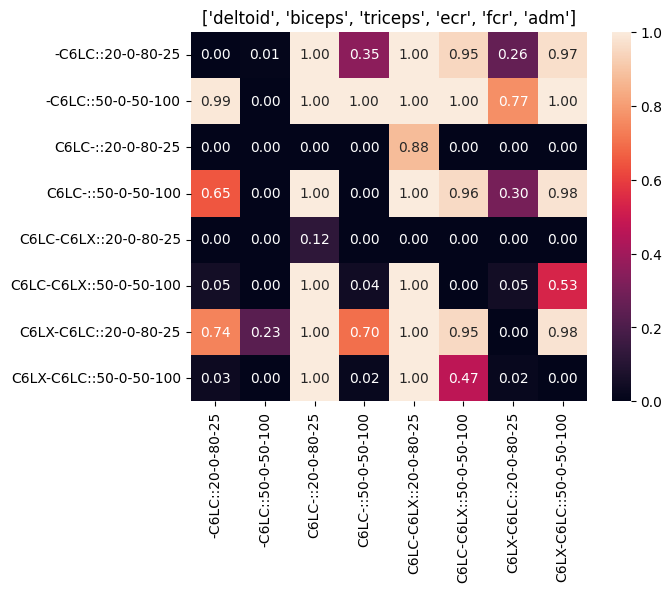

In [21]:
muscles = ["deltoid", "biceps", "triceps", "ecr", "fcr", "adm"]
mat = _process_by_muscles(muscles=muscles)

sns.heatmap(mat, xticklabels=conditions_inv, yticklabels=conditions_inv, annot=True, fmt=".2f")
plt.title(f"{muscles}");

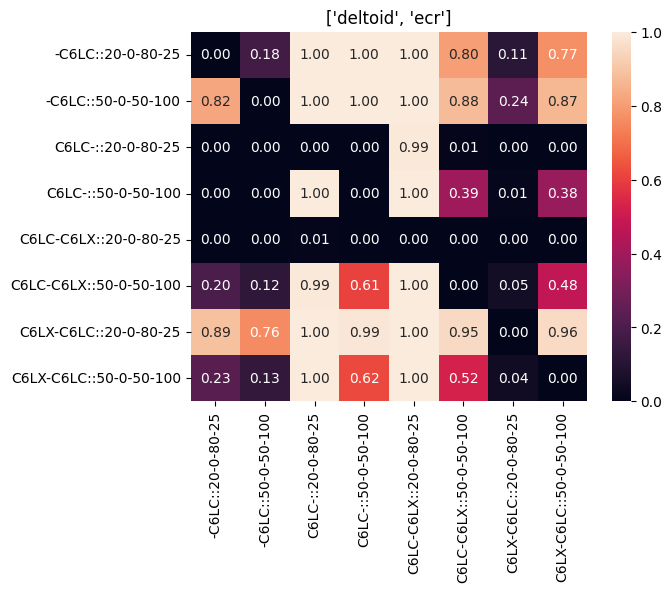

In [32]:
muscles = ["deltoid", "ecr"]
mat = _process_by_muscles(muscles=muscles)

sns.heatmap(mat, xticklabels=conditions_inv, yticklabels=conditions_inv, annot=True, fmt=".2f")
plt.title(f"{muscles}");

In [ ]:
# # num_samples x charge x pos x sub

# left  # num_samples x sub
# right # num_samples x sub

# left - right # num_samples x sub x response

# left - right # num_samples x sub_ x response_ -> num_samples x (sub_ * response_)


# (left - right).mean() # num_samples

# left - right < 0 mean

